# Hollywood Actors 
###  Can we predict if an actor won the Oscar based on the career article in Wikipedia?

Shmuel Naaman 

### Introduction:
Based on your request I analyze the "Holywood Actors" articles in Wikipedia. I choose to use the list of actors that appears on 'Hollywood Walk of Fame motion picture stars'. This is not a complete list of actors but it represents significant stars in the Hollywood industry. The list includes around 900 actors 200 of them were nominated to Oscar and another 200 won an Oscar. 

I thought that building a model that classify actors that won the Oscar, nominated to Oscar and did not win the oscar will demonstrate some of my skills in data processing and modeling. 

Due to obviously limited time, I focus my efforts on efficient preprocessing that will enhance the signal. 
 * I perform basic cleaning of the data 
 * Used nltk sentence tokenizer as an input to create stem words.
 * Remove stop words
 * Perform word embodied as part of the deep neural network. 
 * I choose to use an artificial recurrent neural network (RNN) architecture of the type Long short-term memory (LSTM). LSTM networks are well-suited to classifying, processing and making predictions based on time series data.
 
These steps allow me to reduce the dimension of the problem, and work with relatively clean data. Which is particularly important for this data set which is quite small. 

### importing libraries

In [1]:
import pandas as pd
import wikipedia as wp
import wikipediaapi
import re
from collections import Counter
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords, wordnet
import tensorflow as tf 
import re
import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

## Utils
Optimally these functions would be in a separate file. However, since they include important steps of the analysis I decided to present them here with the rest of the analysis. 


### Clean the data
 * Replace punctuation with tokens so we can use them in our model 
 * Remove the word 'Oscar' from the article
 * Remove the words 'section' and 'Career' since they are related with the articale and not the actor
There are many other preprocessing that worth considering here for example the work 'nomination' 
 

In [2]:

def preprocess(text):
    # Replace punctuation with tokens so we can use them in our model 
    # We remove the word 'Oscar' from the article
    # We did remove the words 'section' and 'Career' since they are related with the articale and not the actor
    # There are many other preprocessing that worth considering here for example the work 'nomination' 
    # We want to keep it simple and at the same time to demonstrate the analysis
     
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('\n', '')
    text = text.replace(':', '')
    text = text.replace('career', ' ')
    text = text.replace('oscar', ' ')
    text = text.replace('section', ' ')


    return  text
 

### Transform the words to roots
 Replace all words by the root words. 
 * That will simplify the dataset by reducing the dimention of the data. 
 * At the same time, considering the size of the data set, having all the variation of a key words as a single category might strength the signal.  
 

In [3]:

# Import nltk resources
resources = ["wordnet", "stopwords", "punkt", \
             "averaged_perceptron_tagger", "maxent_treebank_pos_tagger"]

for resource in resources:
    try:
        nltk.data.find("tokenizers/" + resource)
    except LookupError:
        nltk.download(resource)

# Create Lemmatizer object
lemma = WordNetLemmatizer()

# Stem words
def lemmatize_word(tagged_token):
    """ Returns lemmatized word given its tag"""
    root = []
    for token in tagged_token:
        tag = token[1][0]
        word = token[0]
        if tag.startswith('J'):
            root.append(lemma.lemmatize(word, wordnet.ADJ))
        elif tag.startswith('V'):
            root.append(lemma.lemmatize(word, wordnet.VERB))
        elif tag.startswith('N'):
            root.append(lemma.lemmatize(word, wordnet.NOUN))
        elif tag.startswith('R'):
            root.append(lemma.lemmatize(word, wordnet.ADV))
        else:          
            root.append(word)
    return root

def lemmatize_doc(document):
    """ Tags words then returns sentence with lemmatized words"""
    lemmatized_list = []
    tokenized_sent = sent_tokenize(document)
    for sentence in tokenized_sent:
        # Seperating sentences
        tokenized_word = word_tokenize(sentence)
        # Identify nouns, verbs, adjectives, and adverbs.
        tagged_token = pos_tag(tokenized_word)
        # Clasify to root word
        lemmatized = lemmatize_word(tagged_token)
        lemmatized_list.extend(lemmatized)
    return " ".join(lemmatized_list)

 

[nltk_data] Downloading package wordnet to C:\Users\Shmuel
[nltk_data]     Naaman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Shmuel
[nltk_data]     Naaman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Shmuel Naaman\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     C:\Users\Shmuel Naaman\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!


## Import list of Hollywood Actors names. 
Wikipedia: "List of actors with Hollywood Walk of Fame motion picture stars".

I used the 'wikipedia' library which is awesome and save a lot of work. 

In [4]:

# Get the html source
html = wp.page("List_of_actors_with_Hollywood_Walk_of_Fame_motion_picture_stars").html().encode("UTF-8")
df = pd.read_html(html)[1]

# Replace the header with the first row
new_header = df.iloc[0] 
df = df[1:]  
df.columns = new_header 

# ading a column for the careere 
df['career']='a'

### Data Overview 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899 entries, 1 to 899
Data columns (total 10 columns):
Actor       899 non-null object
nan         899 non-null object
Born        899 non-null object
Died        899 non-null object
Age         899 non-null object
Address     899 non-null object
Inducted    899 non-null object
At age      899 non-null object
Oscar       899 non-null object
career      899 non-null object
dtypes: object(10)
memory usage: 70.3+ KB


Populating the interactive namespace from numpy and matplotlib


,Oscar
Oscar,
Nom,173
Won,176
~,550


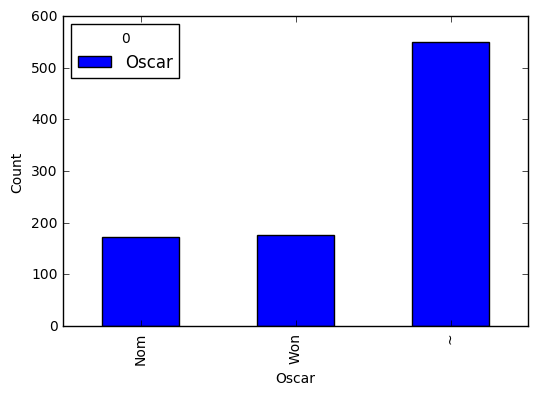

In [6]:
% pylab inline
df.groupby([ 'Oscar'])[['Oscar']].count().plot(kind='bar').set_ylabel('Count')
df.groupby(['Oscar' ])[['Oscar']].count()

#### Figure 1: The 'Nomination' (Nom) and 'Won' are balanced but many actors are not in either of these categories. 

##  Import the actors 'Career' article. 
 * Here we use "wikipediaapi" library to extract the 'Career' section for each actor article that appears in the list.  
 * It is important to note here that the preprocessing is perform as we reading the data. Hopefully, that will save processing time. 

* nltk sentance tokenizer. 
* tag words. 
* root on the original text. stanford nlp library. 
* stop words. 

In [7]:
# Extracting the Career for each actor and adding them to the dataframe
 
all_text=str([])

stop_words = stopwords.words("english")

stop_words = [word.replace("\'", "") for word in stop_words]

wiki_wiki = wikipediaapi.Wikipedia('en')

for ind, actor_n in  enumerate(df.Actor):
    # Uploading the actor article.
    page_py = wiki_wiki.page(actor_n)
    # Extracting the "Career" section and preprocessing the text.
    example_sent = preprocess(lemmatize_doc(str(page_py.section_by_title('Career')))) 
    # Stop words
    section_py = ' '.join([w for w in example_sent.split() if not w in stop_words])    
    # Processed "Career" section saved into a "bag of words" for the encoding 
    all_text += section_py
    
    # Procesed "Career" section added to the dataframe
    df['career'].iloc[ind] = section_py
# "bag of words"
words = all_text.split() 

In [8]:
#del all_text
print('Number of unique words :',len(set(words)))
words[0:30]

Number of words : 29701


['[]<LEFT_PAREN>',
 '1',
 '<RIGHT_PAREN>',
 'sub',
 '<LEFT_PAREN>',
 '3',
 '<RIGHT_PAREN>',
 'lou',
 'costello',
 'hollywood',
 '<LEFT_PAREN>',
 '2',
 '<RIGHT_PAREN>',
 'abbott',
 'cross',
 'path',
 'lou',
 'costello',
 'early',
 '1930s',
 'abbott',
 'produce',
 'perform',
 'minsky',
 "'s",
 'burlesque',
 'show',
 'costello',
 'rise',
 'comic']

In [9]:
df_words =pd.DataFrame(words) 

## Labels
Using one hot encoding to labels categories

In [10]:
columns = [  'Nom','won','non' ]
labels =    pd.DataFrame(  columns=columns)
labels[[ 'Nom','won','non']] =  pd.DataFrame(pd.get_dummies(df['Oscar']))
 

In [11]:
labels.head()

,Nom,won,non
1,0,0,1
2,0,0,1
3,1,0,0
4,0,0,1
5,0,0,1


### Save to file

In [12]:
#df_words.to_csv('words.csv' ,index=False)
#df.to_csv('holly_actr.csv' )
#labels.to_csv('labels.csv' ,index=False)

In [62]:
#df_words = pd.read_csv('words.csv') 
#words = df_words['0'].values.tolist()
#df = pd.read_csv('holly_actr.csv') 
#labels = pd.read_csv('labels.csv') 

### Encoding the words
Each unique word in the 'bag of words' gets an integer. That will be used to encode the text in the data frame.

In [14]:

counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}
 

career_ints = []
for i, each in enumerate(df['career']):
     
    if (each !='none' and each !='a' and  each !='nan'):
        career_ints.append([vocab_to_int[word] for word in each.split()])
    else:
        career_ints.append([0])
 

### Overview for the career articles

In [15]:
review_lens = Counter([len(x) for x in career_ints])
print("1-length reviews: {}".format(review_lens[1]))
print("Maximum review length: {}".format(max(review_lens)))

1-length reviews: 429
Maximum review length: 7139


We find that around half of the actors have no articles. That might be due to a different section name. In some cases, the 'early life' section is combined with the 'career'. This is something that can be solved. However, the data include enough articles to demonstrate the analysis. 

,0
count,899.000000
mean,566.721913
std,904.181918
min,1.000000
25%,1.000000
50%,152.000000
75%,843.500000
max,7139.000000


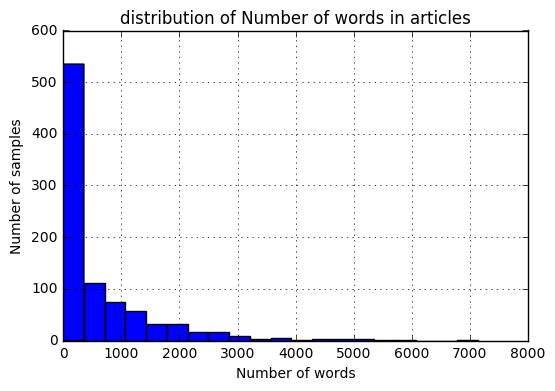

In [54]:
import pylab as pl
#pd.DataFrame.from_dict(  review_lens ) 
review_le =  ([len(x) for x in career_ints])
review_df = pd.DataFrame(review_le)

review_df .hist(bins = 20) 
pl.xlabel('Number of words')
pl.ylabel('Number of samples')
pl.title('distribution of Number of words in articles')
pd.DataFrame(review_df.describe())
 

#### Figure 2: 50% of the articles are shorter than 150 words. The average number of words in the articles is 566 words.  

In [55]:
samp = len(df[ (df['Oscar'] != '~') & (df['career'] != 'none') ])
print("Number of articles that have career section and the actor won or was nominated to Oscar: {}".format(samp))

Number of articles that have career section and the actor won or was nominated to Oscar: 214


### Prepare the data for the model
Create an array of features that contains the data we'll pass to the network. The data come from 'career_ints', since we want to feed integers to the network. Each row is 300 words long. The shorter rows are than pads with 0s. For the long rows, only the first 300 words are used.

In [18]:
seq_len = 300
features = np.zeros((len(career_ints), seq_len), dtype=int)
for i, row in enumerate(career_ints):
    features[i, -len(row):] = np.array(row)[:seq_len]

In [19]:
features

array([[    3,    61,     4, ...,     2,   341,     6],
       [    0,     0,     0, ...,     0,     0,     0],
       [    3,    61,     4, ..., 17307,     1,  3288],
       ...,
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     3,    19,     4],
       [    0,     0,     0, ...,     0,     0,     0]])

## Training, Validation, Test

In [21]:
split_frac = 0.8
split_idx = int(len(features)*0.8)
train_x, val_x = features[:split_idx], features[split_idx:]
train_y, val_y = labels.values[:split_idx ], labels.values[split_idx: ]

test_idx = int(len(val_x)*0.5)
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape),
      "\nTest set: \t\t{}".format(test_y.shape),
     "\nValidation set: \t{}".format(val_y.shape),
     "\nTrain set: \t\t{}".format(train_y.shape))

			Feature Shapes:
Train set: 		(719, 300) 
Validation set: 	(90, 300) 
Test set: 		(90, 300) 
Test set: 		(90, 3) 
Validation set: 	(90, 3) 
Train set: 		(719, 3)


## Build the graph

### Hyperparameters Defining.

* `lstm_size`: Number of units in the hidden layers in the LSTM cells. 
* `lstm_layers`: Number of LSTM layers in the network.
* `batch_size`: The number of articles to feed the network in one training pass.  
* `learning_rate`: Learning rate

In [66]:
tf.reset_default_graph()

lstm_size = 256
lstm_layers = 1
batch_size = 90
learning_rate = 0.001
NUM_CLASSES = 3

For the network itself, we'll be passing in 300 words long vectors. Each batch will be batch_size vectors. We'll also be using dropout on the LSTM layer, so we'll make a placeholder for the keep probability.

In [67]:
n_words = len(vocab_to_int) + 1 # Adding 1 because we use 0's for padding, dictionary started at 1

# Create the graph object
graph = tf.Graph()
# Add nodes to the graph
with graph.as_default():
    inputs_ = tf.placeholder(tf.int32, [None, None], name='inputs')
    labels_ = tf.placeholder(tf.int32, [None, None], name='labels')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

### Embedding

Now we'll add an embedding layer. We need to do this because it is inefficient to one-hot encode our classes here. Instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table. It is also possible to train an embedding layer using word2vec, then load it here.  

In [68]:
# Size of the embedding vectors (number of units in the embedding layer)
embed_size = 300 

with graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_words, embed_size), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs_)

### LSTM cell

 
Next, we'll create our LSTM cells to use in the recurrent network ([TensorFlow documentation](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn)). 

To create a basic LSTM cell for the graph, we'll   use `tf.contrib.rnn.BasicLSTMCell`.

```
tf.contrib.rnn.BasicLSTMCell(num_units, forget_bias=1.0, input_size=None, state_is_tuple=True, activation=<function tanh at 0x109f1ef28>)
```

BasicLSTMCell   takes a parameter `num_units`, the number of units in the cell (`lstm_size`).  

 

Next, we add dropout to the cell with `tf.contrib.rnn.DropoutWrapper`. This just wraps the cell in another cell, but with dropout added to the inputs and/or outputs. It's a really convenient way to make the network better with almost no effort! 


The network will have better performance with more layers. Adding more layers allows the network to learn complex relationships. A simple way to create multiple layers of LSTM cells with `tf.contrib.rnn.MultiRNNCell`:

```
cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
```

Here, `[drop] * lstm_layers` creates a list of cells (`drop`) that is `lstm_layers` long. The `MultiRNNCell` wrapper builds this into multiple layers of RNN cells, one for each cell in the list.

So the final cell we're using in the network is actually multiple  LSTM cells with dropout. But it all works the same from an architectural viewpoint, just a more complicated graph in the cell.

 

In [69]:
with graph.as_default():
    # Basic LSTM cell
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    
    # Dropout to the cell
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    
    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)

### RNN forward pass
Now we need to actually run the data through the RNN nodes. We use tf.nn.dynamic_rnn to do this. We pass in the RNN cell you created (our multiple layered LSTM cell for instance), and the inputs to the network.
outputs, final_state = tf.nn.dynamic_rnn(cell, inputs, initial_state=initial_state)
Above I created an initial state, initial_state, to pass to the RNN. This is the cell state that is passed between the hidden layers in successive time steps. tf.nn.dynamic_rnn takes care of most of the work for us. We pass in our cell and the input to the cell, then it does the unrolling and everything else for us. It returns outputs for each time step and the final_state of the hidden layer.


In [70]:
with graph.as_default():
    outputs, final_state = tf.nn.dynamic_rnn(cell, embed,
                                             initial_state=initial_state)

### Output
#### Training Cost
We only care about the final output, we'll be using that as our prediction. So we need to grab the last output with `outputs[:, -1]`, the calculate the cost from that and `labels_`.

In [71]:
with graph.as_default():
    predictions = tf.contrib.layers.fully_connected(outputs[:, -1], NUM_CLASSES, 
                                                    activation_fn=tf.sigmoid)
    cost = tf.losses.mean_squared_error(labels_, predictions)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

#### Validation accuracy
Here we   calculate the accuracy which I'll use in the validation pass.

In [72]:
with graph.as_default():
    correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
 

#### Batching
This function returning batches from our data. First it removes data such that we only have full batches. Then it iterates through the x and y arrays and returns slices out of those arrays with size [batch_size].

In [139]:
def get_batches(x, y, batch_size=90):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

## Training

Below is the training code. 

In [74]:
epochs = 5
 
with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for e in range(epochs):
        state = sess.run(initial_state)
        
        for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
            feed = {inputs_: x,
                    labels_: y[:, :],
                    keep_prob: 0.5,
                    initial_state: state}
            loss, state, _ = sess.run([cost, final_state, optimizer], feed_dict=feed)
            
            if iteration%5==0:
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(loss))

            if iteration%25==0:
                val_acc = []
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for x, y in get_batches(val_x, val_y, batch_size):
                    feed = {inputs_: x,
                            labels_: y[:,:],
                            keep_prob: 1,
                            initial_state: val_state}
                    batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                    val_acc.append(batch_acc)
             
                print("Val acc: {:.3f}".format(np.mean(val_acc)))
            iteration +=1
    saver.save(sess, "checkpoints/sentiment.ckpt")

Epoch: 0/5 Iteration: 5 Train loss: 0.213
Epoch: 1/5 Iteration: 10 Train loss: 0.187
Epoch: 2/5 Iteration: 15 Train loss: 0.146
Epoch: 2/5 Iteration: 20 Train loss: 0.157
Epoch: 3/5 Iteration: 25 Train loss: 0.163
Val acc: 0.719
Epoch: 4/5 Iteration: 30 Train loss: 0.139
Epoch: 4/5 Iteration: 35 Train loss: 0.165


## Testing

In [75]:
test_acc = []
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
        feed = {inputs_: x,
                labels_: y[:, :],
                keep_prob: 1,
                initial_state: test_state}
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.3f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints\sentiment.ckpt
Test accuracy: 0.704


### Single case
We can enter a actor name and the model will categorize whather it win was nominated or none. 

In [229]:
actor_n='Javier Bardem'
page_py = wiki_wiki.page(actor_n)
# Extracting the "Career" section and preprocessing the text.
example_sent = preprocess(lemmatize_doc(str(page_py.section_by_title('Career')))) 
# Stop words
section_py = ' '.join([w for w in example_sent.split() if not w in stop_words])    

each = section_py

career_ints = []

if (each !='none' and each !='a' and  each !='nan'):
    career_ints.append([vocab_to_int[word] for word in each.split()])
else:
    career_ints.append([0])

seq_len = 300
features = np.zeros((len(career_ints), seq_len), dtype=int)
row = career_ints

for i, row in enumerate(career_ints):
    features[i, -len(row):] = np.array(row)[:seq_len]

samp = features[0,:].reshape(1,300)
test_x1=test_x
test_x1[0]=samp 

In [230]:
 
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    #for ii, (x, y) in enumerate(get_batches(samp_x, samp_y  , batch_size), 1):
 
    feed = {inputs_: test_x1, 
                keep_prob: 1,
                initial_state: test_state}
    pred1  = sess.run([predictions ], feed_dict=feed)
 
    print(actor_n,['Nom','Won','Nan'][np.where(pred1[0][0]==np.max(pred1[0][0]))[0][0]] ) 

INFO:tensorflow:Restoring parameters from checkpoints\sentiment.ckpt
Javier Bardem Won


In [233]:
def actor_oscar(actor_n):
     
    page_py = wiki_wiki.page(actor_n)
    # Extracting the "Career" section and preprocessing the text.
    example_sent = preprocess(lemmatize_doc(str(page_py.section_by_title('Career')))) 
    # Stop words
    section_py = ' '.join([w for w in example_sent.split() if not w in stop_words])    

    each = section_py

    career_ints = []

    if (each !='none' and each !='a' and  each !='nan'):
        career_ints.append([vocab_to_int[word] for word in each.split()])
    else:
        career_ints.append([0])

    seq_len = 300
    features = np.zeros((len(career_ints), seq_len), dtype=int)
    row = career_ints

    for i, row in enumerate(career_ints):
        features[i, -len(row):] = np.array(row)[:seq_len]

    samp = features[0,:].reshape(1,300)
    test_x1=test_x
    test_x1[0]=samp 
    with tf.Session(graph=graph) as sess:
        saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
        test_state = sess.run(cell.zero_state(batch_size, tf.float32))
        #for ii, (x, y) in enumerate(get_batches(samp_x, samp_y  , batch_size), 1):

        feed = {inputs_: test_x1, 
                    keep_prob: 1,
                    initial_state: test_state}
        pred1  = sess.run([predictions ], feed_dict=feed)

    print(actor_n,['Nom','Won','Nan'][np.where(pred1[0][0]==np.max(pred1[0][0]))[0][0]] ) 
    

In [ ]:
actor_oscar('Javier Bardem')

INFO:tensorflow:Restoring parameters from checkpoints\sentiment.ckpt


## Reflection

The model performs better than I expected, I find that somehow suspicious! I would like to find out what are the main reasons for that high performance.  

Optional sources that should be examined:  
 * The length of the article. I suspect that Oscar nomination and Oscar holders will have longer text. 
 * The word 'nomination' (or other words) with all its variation might bias the text. 
 * The metric that we choose together with the unbalanced labels might bias the results. The metric considers the performance of the model for the 3 categories. Perhaps a more focus metric will show a different result. 
 * Comparing the performance to some baseline. For example, What will be the accuracy if all prediction is "not nominated and not won". 
 
### Improvements 
 * The preprocessing was quite basic, there are other approaches for data preprocessing that can be used. 
 * Larger data set will allow us to use the actual words instead of the roots. 
 * Not all the possible articles where uploaded. Better data collection will increase the information in the dataset. 
 * The model was quite simple, we can increase the number of hidden layers and the number of neurons. We can use other models.  
 * The cleaning of the data can be more sophisticated. We can easily remove words with very high or very low frequency. Some of the words in the articles are related to numbering the sections that can be removed. 

### Reference 
#### # Extracting the names of actors and the oscar nomination :  https://qxf2.com/blog/web-scraping-using-python/

#### # Extracting the career : https://pypi.org/project/Wikipedia-API/0.2.0/
#### # Model : https://github.com/udacity/deep-learning/blob/master/sentiment-rnn/Sentiment_RNN_Solution.ipynb